# STL-single company ROPC & AOV

In [1]:
import libs.config as config
import libs.hyperparam as hyperparam
import libs.util as util 
import libs.customized_dataset as customized_dataset
import libs.models as models 
import libs.forecasting as forecasting 
import libs.plots as plots 

import os  # for interacting with the operating system
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # for debugging cuda errors
import glob  # for finding files in directories
import warnings 
warnings.filterwarnings('ignore') # for ignoring all warnings
# import argparse  # for parsing command line arguments (for running from the terminal)

import random
import math # for math operations
import time  # for time-related functionalities
import holidays # for checking if a date is a holiday
import matplotlib.pyplot as plt  # for plotting
plt.set_cmap('cividis') # color map for the plots to 'cividis'
## Enable the display of matplotlib plots inline in a Jupyter notebook
%matplotlib inline 
import matplotlib.ticker as ticker # for customizing the plots' tick locations and labels
import numpy as np  # for numerical computations
import pandas as pd  # for data manipulation and analysis
pd.set_option('display.max_columns', None) # to display all columns
from datetime import date, datetime, timedelta  # for working with dates and times

from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer  # for scaling data
from tqdm import tqdm  # for creating progress bars

import torch  # for building and training neural networks
from torch.utils.data import Dataset, DataLoader # for loading and managing datasets
import torch.nn as nn  # for building neural networks
import torch.nn.functional as F  # for implementing various activation functions
import torch.optim as optim  # for defining optimizers

# set the device as GPU with index 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
config.get_environ_info(device)

config.py is loaded.


hyperparam.py is loaded.
util.py is loaded.
customized_dataset.py is loaded.
model.py is loaded.
forecasting.py is loaded.
plot.py is loaded.

pandas version: 2.0.3
pytorch version: 2.0.0+cu118

Device: cuda:0
CUDA version: 11.8
GPU spec: Tesla T4

Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Random seed: 0 for torch and numpy.

Current working directory: /home/kkim476/dl-cbcv/mtl/main


<Figure size 640x480 with 0 Axes>

### Check NVIDIA GPU

In [2]:
# !nvidia-smi

### Set data path

In [3]:
## Google cluster
READ_DIR = r"/home/kkim476/dl-cbcv/data/weekly_cohort_data_1000_missing_filled_final"
WORK_DIR = r"/home/kkim476/dl-cbcv"

### Set prediction target, covariates, and save mode

In [4]:
# set prediction target
PREDICTION_GOAL = 'repeat_order_per_customer' 
TARGET_TASK = config.get_target_variable_name(PREDICTION_GOAL)

### set covariate features
USE_EMBEDDING = False
COHORT_EMBEDDING = True
DUMMY_VAR = False # entity embedding, rather than one hot encoding

### folder path for saving results
SAVE_MODE = False
SAVE_DIR = f'{WORK_DIR}/results/stl_onecomp_{PREDICTION_GOAL}'
SAVE_MODEL, SAVE_EPOCH, SAVE_PLOT, SAVE_PREDICT, SAVE_ACTUAL = config.create_save_folders(SAVE_MODE, SAVE_DIR)

### Select one focal company or for-loop

In [5]:
## toy or debugging mode (single company)=====================
MERCHANT_NAME = config.TOY_MERCHANT_NAME_LIST[0]
filepath = util.get_company_file(READ_DIR, MERCHANT_NAME)



# ### for loop mode ===========================================
# _, idx_parentmerchant_merchant, parentmerchant_merchant = util.get_file_lists(READ_DIR)

# for MERCHANT_NAME in idx_parentmerchant_merchant:
#     print(f'\n\n\n{MERCHANT_NAME} starts!')
#     filepath = util.get_company_file(READ_DIR, MERCHANT_NAME)
#     break

filepath: /home/kkim476/dl-cbcv/data/weekly_cohort_data_1000_missing_filled_final/102_shopify_adjusted_shopify_payments_cohort.csv


## Data Preparation

### Load data

In [6]:
## this file is cohort-week level aggregated panel data after ETL of raw earnest transaction DB
raw_df = pd.read_csv(f'{filepath}', parse_dates=['acq_week','week'])
raw_df = util.change_raw_df_column_names(raw_df, MERCHANT_NAME, hyperparam.TRAIN_START, hyperparam.TEST_START,
                                         group_identifier='acq_week', time_identifier='week',
                                         acquisition_identifier='N_week_cohort',
                                         order_identifier = 'orders',
                                         spend_identifier = 'spend')
raw_df = util.generate_behaviorfeatures(raw_df)

FREQ, week_start = util.get_week_start(raw_df, hyperparam.TRAIN_START, hyperparam.TEST_START, hyperparam.TEST_END) # this will be used for generating zero padding, calendar covariates etc

week start day is 6, w-SUN, Sunday
observed (train start to test end) period (weeks) 118
unobserved (test start to test end) period (weeks) 47


### Zero padding

This is technical but important piece regarding how to handle 'cohort' triangle data.

In [7]:
# columns that I want to keep
company_static = ['merchant_index', 'merchant', 'parent_merchant', 'category', 'subcategory']
if USE_EMBEDDING:
    company_static = company_static + ['merchant_emb_int', 'merchant_name']
# company_dynamic = ['cohort_size', 'active_users', 
#                    'orders','rpt_orders','initial_order',
#                    'spend','rpt_spend','initial_spend',
#                    'initial_aov','rpt_aov',
#                    ]
company_dynamic = []

assert all(column in list(raw_df.columns) for column in company_static + company_dynamic), \
    'some columns are missing in the raw_df'
    
df_padded = util.zero_padding(raw_df, [TARGET_TASK], company_static, company_dynamic, hyperparam.INPUT_CHUNK_LENGTH, FREQ)


before: 48828 rows
after: 51948 rows


### Generate calendar time covariates

Our covariates include:
- week of year_t+1 (1 week ahead) : (categorical) one-hot encoding. 53 variables.
- holidays_t+1 (1 week ahead) : (binary) dummy variable. 1 variable.
- global trend_t : (continuous) quadratic. 2 variables.
- cohort numbering_i : (continuous) quadratic. 2 variables.
- cohort tenure_it : (continuous) quadratic. 2 variables.

In [9]:
df_padded_w_cov, country_holidays = util.generate_calendartime_features(df_padded, FREQ, week_start)
# util.check_holidays(df_padded_w_cov, country_holidays)
df_padded_w_cov = util.generate_cohort_features(df_padded_w_cov, [TARGET_TASK], COHORT_EMBEDDING, DUMMY_VAR, hyperparam.COHORT_EMB_NUM)

322 weeks in our zero padded raw data
53 holiday weeks are identified



In [10]:
## limit data range
df = df_padded_w_cov[df_padded_w_cov['group']<=hyperparam.TEST_END] # limit cohort
df = df[df['time']>=hyperparam.TRAIN_START_with_offset][(df['time']<=hyperparam.TEST_END)] # limit time window

## get covariate feature names
COVARIATE_FEATURE_NAMES, covariate_name_to_index = config.get_covariate_variable_name(df, USE_EMBEDDING, COHORT_EMBEDDING, DUMMY_VAR)
print(COVARIATE_FEATURE_NAMES)
df

['holidays_1w_ahead', 'linear_trend', 'quadratic_trend', 'tenure_scaled', 'quad_tenure_scaled', 'week_int', 'cohort_month_int', 'group_censored_int']


,group,time,tenure,rpt_orders_per_cust,merchant_index,merchant,parent_merchant,category,subcategory,week_int,holidays_1w_ahead,linear_trend,quadratic_trend,group_int,attention_mask,cohort_month_int,group_censored,group_censored_int,tenure_scaled,quad_tenure_scaled
53,2015-12-27,2016-10-23,43,0.035512,102,shopify_payments,shopify_adjusted,Finance,Payment Facilitators,42,0,0,0,0,0,12,2015-12-27,0,0.165109,0.027261
54,2015-12-27,2016-10-30,44,0.041688,102,shopify_payments,shopify_adjusted,Finance,Payment Facilitators,43,1,0,0,0,0,12,2015-12-27,0,0.168224,0.028299
55,2015-12-27,2016-11-06,45,0.042203,102,shopify_payments,shopify_adjusted,Finance,Payment Facilitators,44,0,0,0,0,0,12,2015-12-27,0,0.171340,0.029357
56,2015-12-27,2016-11-13,46,0.046835,102,shopify_payments,shopify_adjusted,Finance,Payment Facilitators,45,1,0,0,0,0,12,2015-12-27,0,0.174455,0.030434
57,2015-12-27,2016-11-20,47,0.056613,102,shopify_payments,shopify_adjusted,Finance,Payment Facilitators,46,0,0,0,0,0,12,2015-12-27,0,0.177570,0.031531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46444,2020-02-23,2020-01-26,-4,0.000000,102,shopify_payments,shopify_adjusted,Finance,Payment Facilitators,4,0,0,0,217,1,2,2017-11-26,100,0.000000,0.000000
46445,2020-02-23,2020-02-02,-3,0.000000,102,shopify_payments,shopify_adjusted,Finance,Payment Facilitators,5,0,0,0,217,1,2,2017-11-26,100,0.000000,0.000000
46446,2020-02-23,2020-02-09,-2,0.000000,102,shopify_payments,shopify_adjusted,Finance,Payment Facilitators,6,1,0,0,217,1,2,2017-11-26,100,0.000000,0.000000
46447,2020-02-23,2020-02-16,-1,0.000000,102,shopify_payments,shopify_adjusted,Finance,Payment Facilitators,7,0,0,0,217,1,2,2017-11-26,100,0.000000,0.000000


In [11]:
del df_padded
del df_padded_w_cov
del country_holidays

### Split into train:val:test (time-wise) X censored:uncensored (group-wise)

<img src="../img/cohort_triangle.png" alt="cohort_triangle" width="600" height="400">

For censored (cohort 0) group of cohorts (who acquired in 2016)
- (A) train: ~ 2018
- (B) validation : '2019-01-01' ~ '2019-03-31'
- (C) test : '2019-04-01' ~

For uncensored (cohort 1~) group of cohorts (who acquired in 2017~)
- (D) train: ~ 2018
- (E) validation : '2019-01-01' ~ '2019-03-31'
- (F) test : '2019-04-01' ~

We do not distinguish between censored and uncensored cohorts in training. We found empirically that it is better to train them together by obtaining more samples at the cost of giving up incorporating heterogeneity between two.



In [12]:
(main_df, main_df_train, main_df_valid, main_df_test, 
 censored_df, censored_df_train, censored_df_valid, censored_df_test) = util.split_dataframe(
    df, hyperparam.TRAIN_START, hyperparam.VAL_START, hyperparam.TEST_START, 
    hyperparam.VAL_START_with_offset, hyperparam.TEST_START_with_offset, hyperparam.VAL_LOSS)

censored_df_train: cohorts 53 * sequence length [115 to 115]
censored_df_valid: cohorts 53 * sequence length [23 to 23]
censored_df_test: cohorts 53 * sequence length [57 to 57]
main_df_train: cohorts 105 * sequence length [115 to 11]
main_df_valid: cohorts 118 * sequence length [23 to 11]
main_df_test: cohorts 165 * sequence length [57 to 11]


### Transform data frame to scaled numpy array

1. As numpy array is more efficient to handle, we transform pandas data frame into numpy array.

2. For each task, we scale the data with its own scaler. This is important for multi-task learning as each task has different scale.

In [13]:
## entire sequences (unscaled)
whole_dict = util.df_to_numpy(df, TASKS=[TARGET_TASK], COVARIATES=COVARIATE_FEATURE_NAMES)

## main cohorts' sequences
main_train_dict = util.df_to_scaled_numpy(main_df_train, [TARGET_TASK], COVARIATE_FEATURE_NAMES)
main_test_dict = util.df_to_scaled_numpy(main_df_test, [TARGET_TASK], COVARIATE_FEATURE_NAMES,  main_train_dict['scaler'])
if hyperparam.VAL_LOSS:
    main_val_dict = util.df_to_scaled_numpy(main_df_valid, [TARGET_TASK], COVARIATE_FEATURE_NAMES, main_train_dict['scaler'])

## censored cohorts' sequences
censored_train_dict = util.df_to_scaled_numpy(censored_df_train, [TARGET_TASK], COVARIATE_FEATURE_NAMES, main_train_dict['scaler'])
censored_test_dict = util.df_to_scaled_numpy(censored_df_test, [TARGET_TASK], COVARIATE_FEATURE_NAMES, main_train_dict['scaler'])
if hyperparam.VAL_LOSS:
    censored_val_dict = util.df_to_scaled_numpy(censored_df_valid, [TARGET_TASK], COVARIATE_FEATURE_NAMES, main_train_dict['scaler'])


## Dataset and DataLoader
the creation of custom datasets, and the initialization of the DataLoader.
- custom dataset class will group the data by the group column
- collate function will handle the padding and attention masking

<img src="../img/data%20period%20and%20samples.png" alt="data_period" width="600" height="400">

<img src="../img/input%20output%20format.png" alt="input_output" width="600" height="400">



### Generate train loader and validation loader

In [14]:
from libs.customized_dataset import CrossSectionalTimeSeriesDataset, collate_fn, value_dict_to_np
import multiprocessing

## Create a TimeSeriesDataset instance and initialize DataLoader for each data
value_train = {key: main_train_dict['scaled_value_seq_dict'].get(key, []) +\
  censored_train_dict['scaled_value_seq_dict'].get(key, []) \
    for key in set(main_train_dict['scaled_value_seq_dict']) | set(censored_train_dict['scaled_value_seq_dict'])}
cov_train = main_train_dict['cov_seq'] + censored_train_dict['cov_seq']
value_train_np = value_dict_to_np(value_train, [TARGET_TASK]) # shape: (num_groups, seq_len, num_tasks)
train_dataset = CrossSectionalTimeSeriesDataset(value_train_np, cov_train, hyperparam.INPUT_CHUNK_LENGTH)

## To be iterated over batches of data during training
train_loader = DataLoader(train_dataset,
                          batch_size=hyperparam.BATCH_SIZE, # how many samples per batch to load
                          shuffle=True, # have the data reshuffled at every epoch to reduce model overfitting
                          drop_last=False, # If False and the size of dataset is not divisible by the batch size, then the last batch will be smaller
                          collate_fn=collate_fn,
                          pin_memory=True, # True for faster data transfer to GPUs, False if out of memory
                          num_workers=multiprocessing.cpu_count()//2,
                        #   num_workers=hyperparam.NUM_WORKERS, # how many subprocesses to use for data loading. (0: loaded in the main process)
                          )

if hyperparam.VAL_LOSS:
    value_valid = {key: main_val_dict['scaled_value_seq_dict'].get(key, []) +\
        censored_val_dict['scaled_value_seq_dict'].get(key, []) \
            for key in set(main_val_dict['scaled_value_seq_dict']) | set(censored_val_dict['scaled_value_seq_dict'])}
    cov_valid = main_val_dict['cov_seq'] + censored_val_dict['cov_seq']
    value_valid_np = value_dict_to_np(value_valid, [TARGET_TASK]) # shape: (num_groups, seq_len, num_tasks)
    val_dataset = CrossSectionalTimeSeriesDataset(value_valid_np, cov_valid, hyperparam.INPUT_CHUNK_LENGTH)
    val_loader = DataLoader(val_dataset, batch_size=hyperparam.BATCH_SIZE, shuffle=False, drop_last=False, # no shuffle for validation
                              collate_fn=collate_fn,
                              )

## get the dimension of the target and covariate data
first_sample = next(iter(train_dataset)) # or train_dataset[0]
first_batch = next(iter(train_loader))

## number of targets, number of covariate features
tgt_dim, cov_dim = first_sample["target"].shape[1], first_sample["covariate"].shape[1] # 3 , 60


## Model

If considering attention mask later, modify with this:
- `def forward(self, src, attention_mask):`
- `x = self.transformer(src=src, tgt=tgt, src_key_padding_mask=attention_mask)`

## Training (Estimation)

In [15]:
## For memory monitoring ==
# !pip install memory_profiler
# %load_ext memory_profiler
# %memit my_function()

In [16]:
from libs.models import STL_Transformer

## initialize model
model = STL_Transformer(
    input_dim=tgt_dim + cov_dim,
    feature_dict=covariate_name_to_index, #
).to(device)

## define optimizer and loss criterion
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparam.LEARNING_RATE)
loss_criterion = torch.nn.MSELoss()

## initialize empty list for losses and early stop
train_losses, valid_losses = [], []
pre_valid_loss, cnt_no_improve = np.inf, 0


In [18]:
for epoch in tqdm(range(hyperparam.N_EPOCHS), desc="training", unit="epoch"):
    train_loss = 0.0 # within each epoch, initialize train loss to 0

    for target_input, cov_input, gt in train_loader:
        optimizer.zero_grad() # reset optimizer gradients to zero
        train_input = torch.cat((target_input,cov_input), dim=-1).to(device)   
        next_value = model(train_input) # forward pass data through the model
        loss = loss_criterion(next_value, gt.to(device)) # calculate and update loss 
        train_loss += loss.item() # accumulate batch loss within each epoch
        loss.backward() # backpropagation
        _ = nn.utils.clip_grad_norm_(model.parameters(), hyperparam.GRADCLIP) # clip gradients to prevent exploding gradients
        optimizer.step() # update parameters based on gradients

    train_losses.append(train_loss/len(train_loader)) # append total train loss for each epoch

    if hyperparam.VAL_LOSS:
        valid_loss = 0.0
        for target_input, cov_input, gt in val_loader:
            valid_input = torch.cat((target_input,cov_input), dim=-1).to(device)
            next_value = model(valid_input)
            loss = loss_criterion(next_value, gt.to(device))
            valid_loss += loss.item()

        valid_losses.append(valid_loss/len(val_loader))
        
        # Early stop evaluate
        if pre_valid_loss - valid_loss  < hyperparam.MINDELTA:
            cnt_no_improve += 1
            if cnt_no_improve > hyperparam.PATIENCE:
                break
        else:
            cnt_no_improve = 0
            
        pre_valid_loss = valid_loss
    
    if epoch % 10 == 0:
        print("train_loss:{:.4f}".format(train_loss))
        print("val loss: {:.4f}".format(valid_loss))

training:  50%|█████     | 1/2 [00:04<00:04,  4.15s/epoch]

train_loss:0.4603
val loss: 0.1315


training: 100%|██████████| 2/2 [00:08<00:00,  4.21s/epoch]


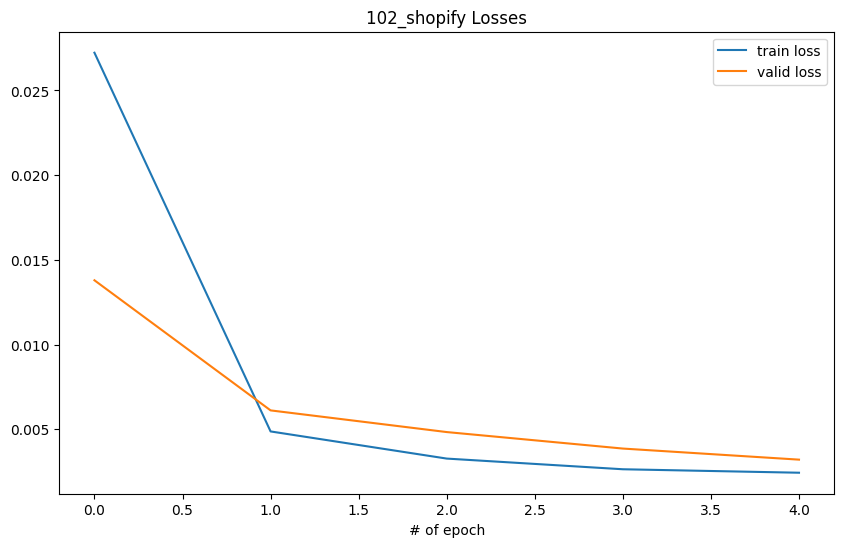

In [19]:
def plot_losses():
    plt.figure(figsize=(10, 6))
    plt.xlabel("# of epoch")
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.title(f"{MERCHANT_NAME} Losses")
    plt.legend()
        
plot_losses()

In [20]:
import pickle

if SAVE_MODE:
    # To save the model
    with open(f'{SAVE_MODEL}/{MERCHANT_NAME}.pkl', 'wb') as file:
        pickle.dump(model, file)

    # # To load the model
    # with open(f'{SAVE_MODEL}/{MERCHANT_NAME}.pkl', 'rb') as file:
    #     model = pickle.load(file)


## Prediction (Inference)

- Rolling forecast origin or walk-forward validation (which means generating predictions one step at a time and conditioning upon the predicted values)

For each rolling window:
- Use the last `INPUT_CHUNK_LENGTH` weeks of data as input to forecast the next week.
- Append the forecasted value to the actual data.
- Move the window one week forward and repeat.

*NOTE:* Error can be accumulated in **triple** way as we now take acq_hat, repeat order per customer_hat, aov_hat all together for next acq prediction,for example.

### Cohort 1 (acquired after the beginning of train period)

In [21]:
from libs.forecasting import prepare_TimeSeriesDataset, rolling_forecast_stl

# Sets the module in evaluation mode
model.eval()

# rolling forecast (scaled)
main_value_test_np = value_dict_to_np(main_test_dict['scaled_value_seq_dict'], [TARGET_TASK])
test_datasets = prepare_TimeSeriesDataset(main_value_test_np, main_test_dict['cov_seq'], 
                                          CrossSectionalTimeSeriesDataset, hyperparam.INPUT_CHUNK_LENGTH)
main_value_test_pred = rolling_forecast_stl(test_datasets, model, device, TARGET_TASK)

# get ground truth in the test period
main_df_test_net = main_df_test[main_df_test['time']>=hyperparam.TEST_START][main_df_test['tenure']>=0]
actual_main = main_df_test_net[['group', 'time'] + [TARGET_TASK]]

# scale back the forecast
predicted_main = util.inverse_scale_np_to_dataframe(main_train_dict['scaler'], main_value_test_pred, main_df_test_net)
predicted_main.sort_values(['group', 'time'], inplace=True)

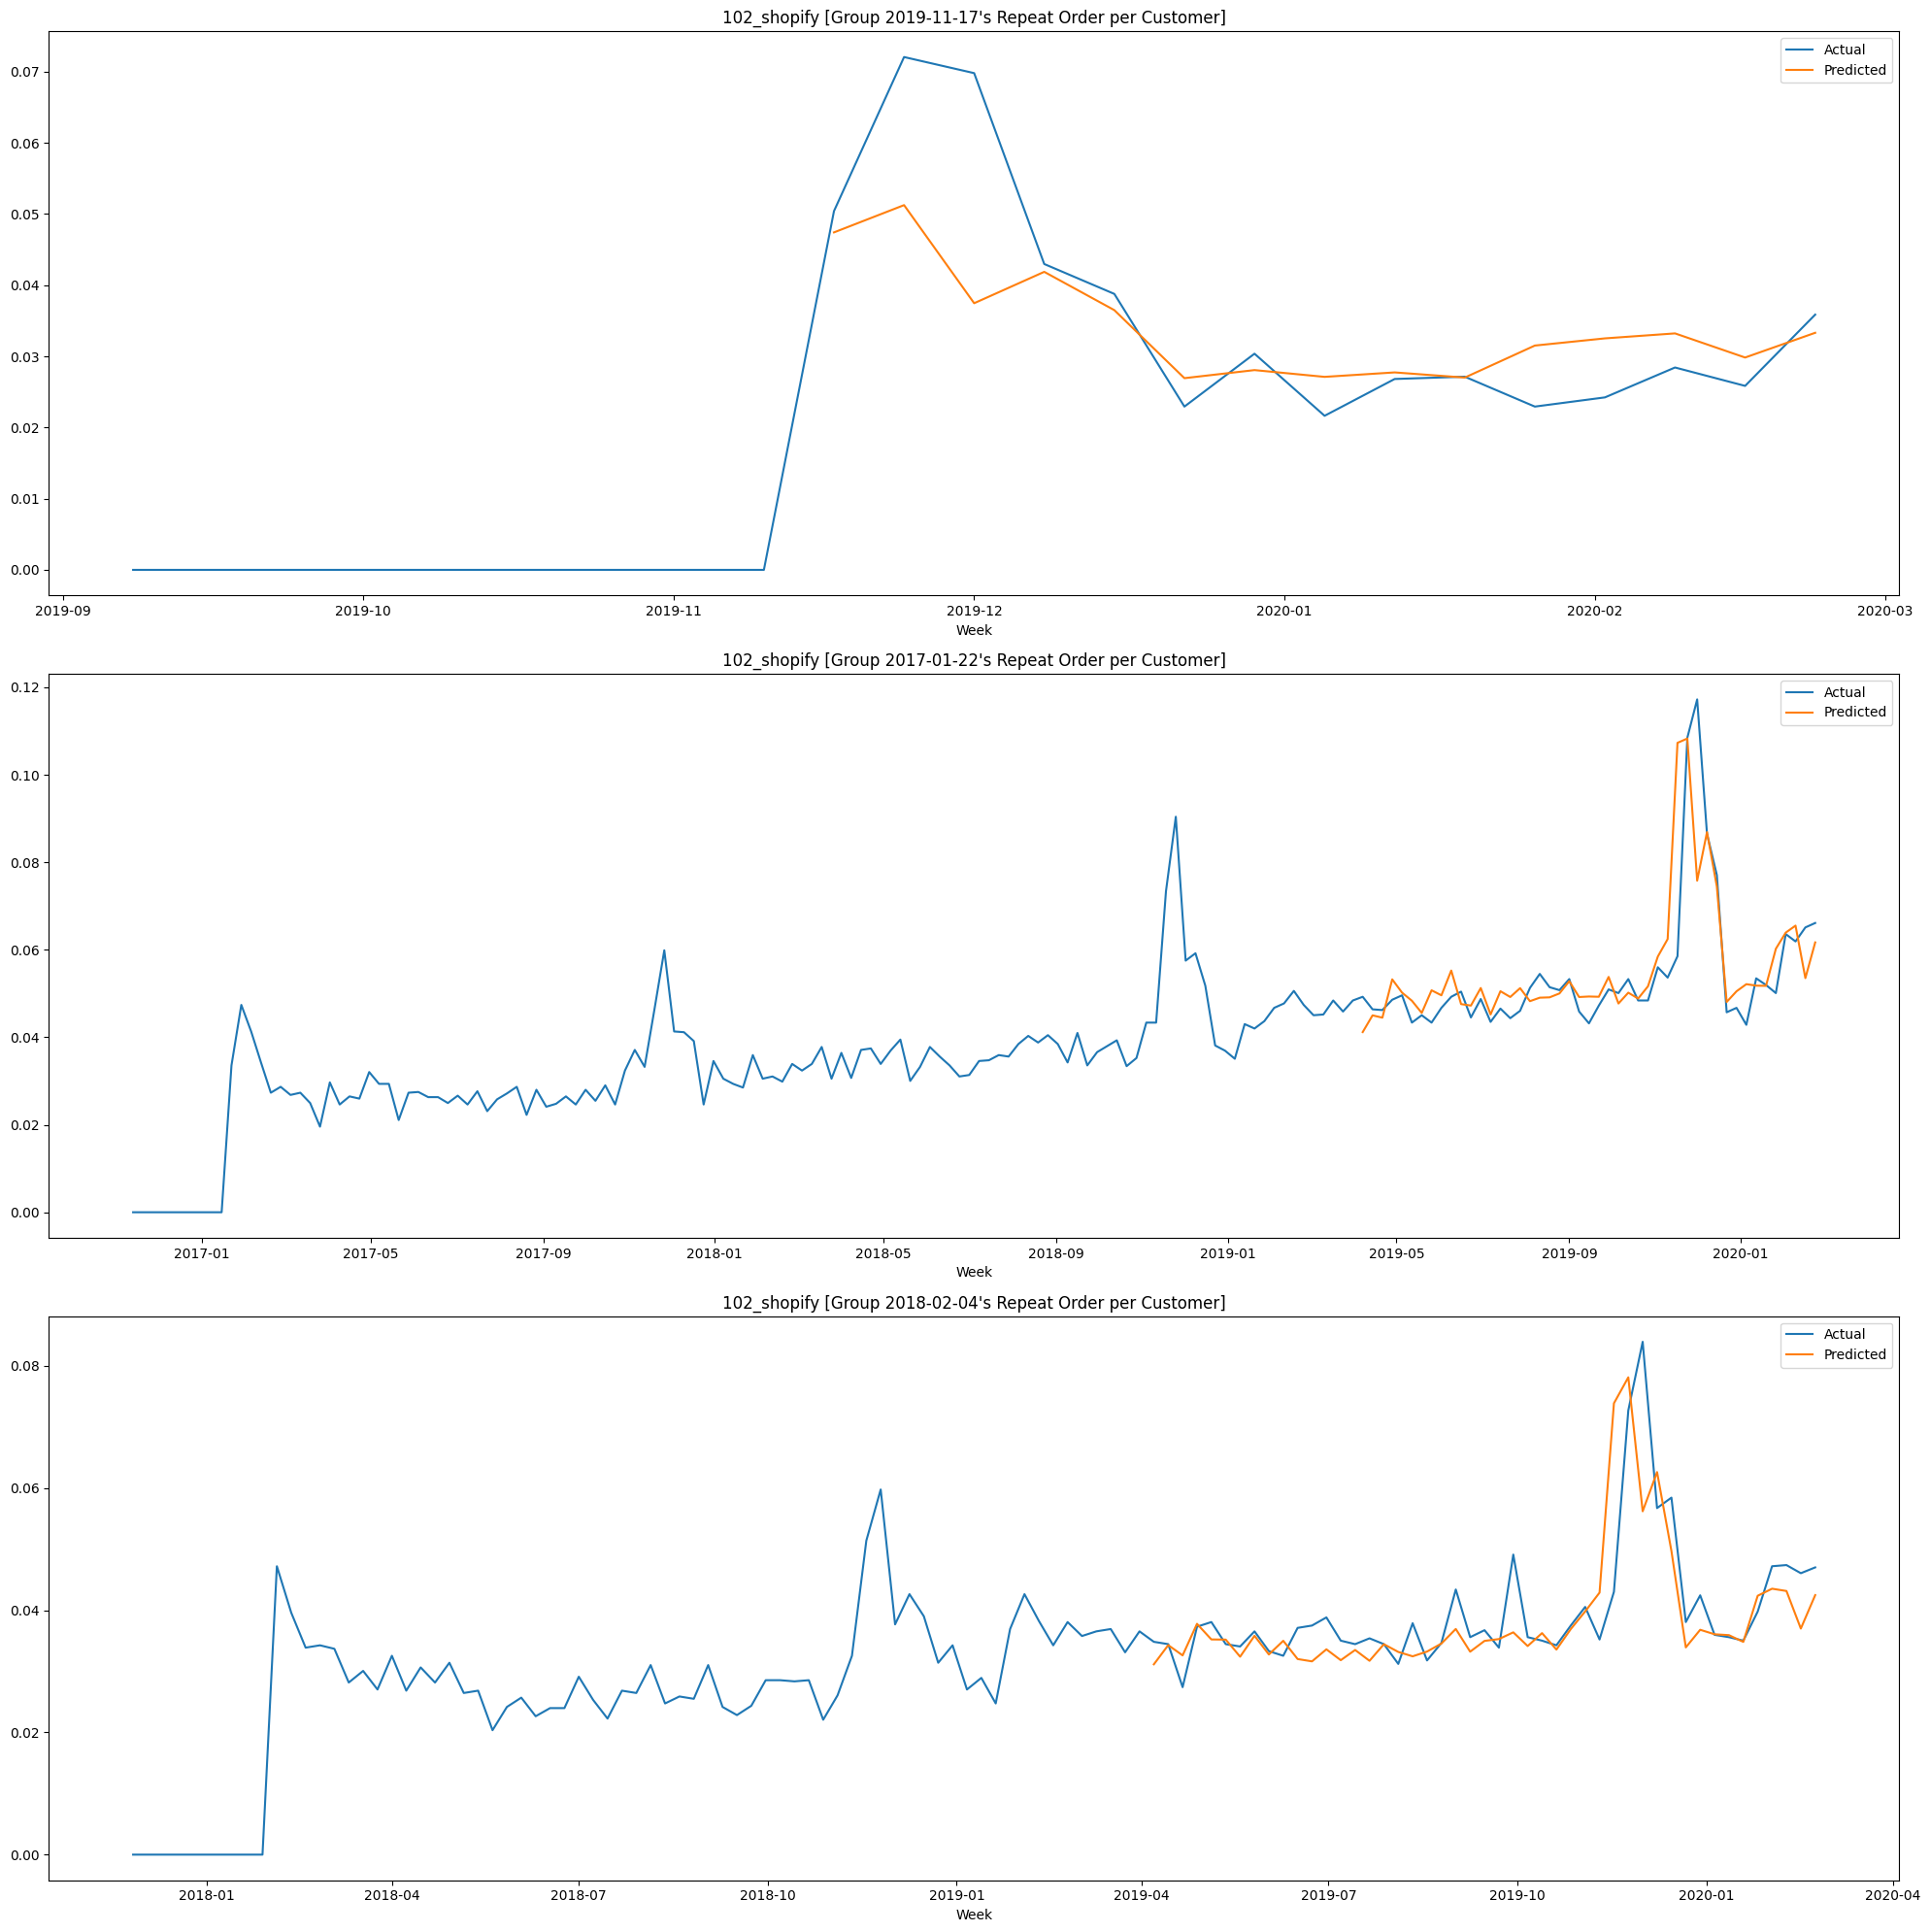

In [22]:
from libs.plots import plot_time_series_multiple

def plot_ropc_cohort1():
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))  # 5 rows, 1 column
    selected_group_indices = random.sample(range(len(main_test_dict['group_seq'])), 3)
    for i, group_index in enumerate(selected_group_indices):
        group = main_test_dict['group_seq'][group_index]
        plot_time_series_multiple(
            main_df[main_df['group'] == group], predicted_main[predicted_main['group'] == group],
            'time', TARGET_TASK, 
            title=f'{MERCHANT_NAME} [Group {group}\'s Repeat Order per Customer]',
            ax=axs[i]
        )
    plt.tight_layout()

plot_ropc_cohort1()

### Cohort 0 (acquired before the beginning of train period)

In [23]:
# Sets the module in evaluation mode
model.eval()

# rolling forecast (scaled)
censored_value_test_np = value_dict_to_np(censored_test_dict['scaled_value_seq_dict'], [TARGET_TASK])
censored_test_datasets = prepare_TimeSeriesDataset(censored_value_test_np, censored_test_dict['cov_seq'], 
                                                   CrossSectionalTimeSeriesDataset, hyperparam.INPUT_CHUNK_LENGTH)
censored_value_test_pred = rolling_forecast_stl(censored_test_datasets, model, device, TARGET_TASK)

# get ground truth in the test period
censored_df_test_net = censored_df_test[censored_df_test['time']>=hyperparam.TEST_START][censored_df_test['tenure']>=0]
actual_censored = censored_df_test_net[['group', 'time'] + [TARGET_TASK]]

# scale back the forecast
predicted_censored = util.inverse_scale_np_to_dataframe(censored_test_dict['scaler'], censored_value_test_pred, censored_df_test_net)
predicted_censored.sort_values(['group', 'time'], inplace=True)

#### Repeat order per customer plot

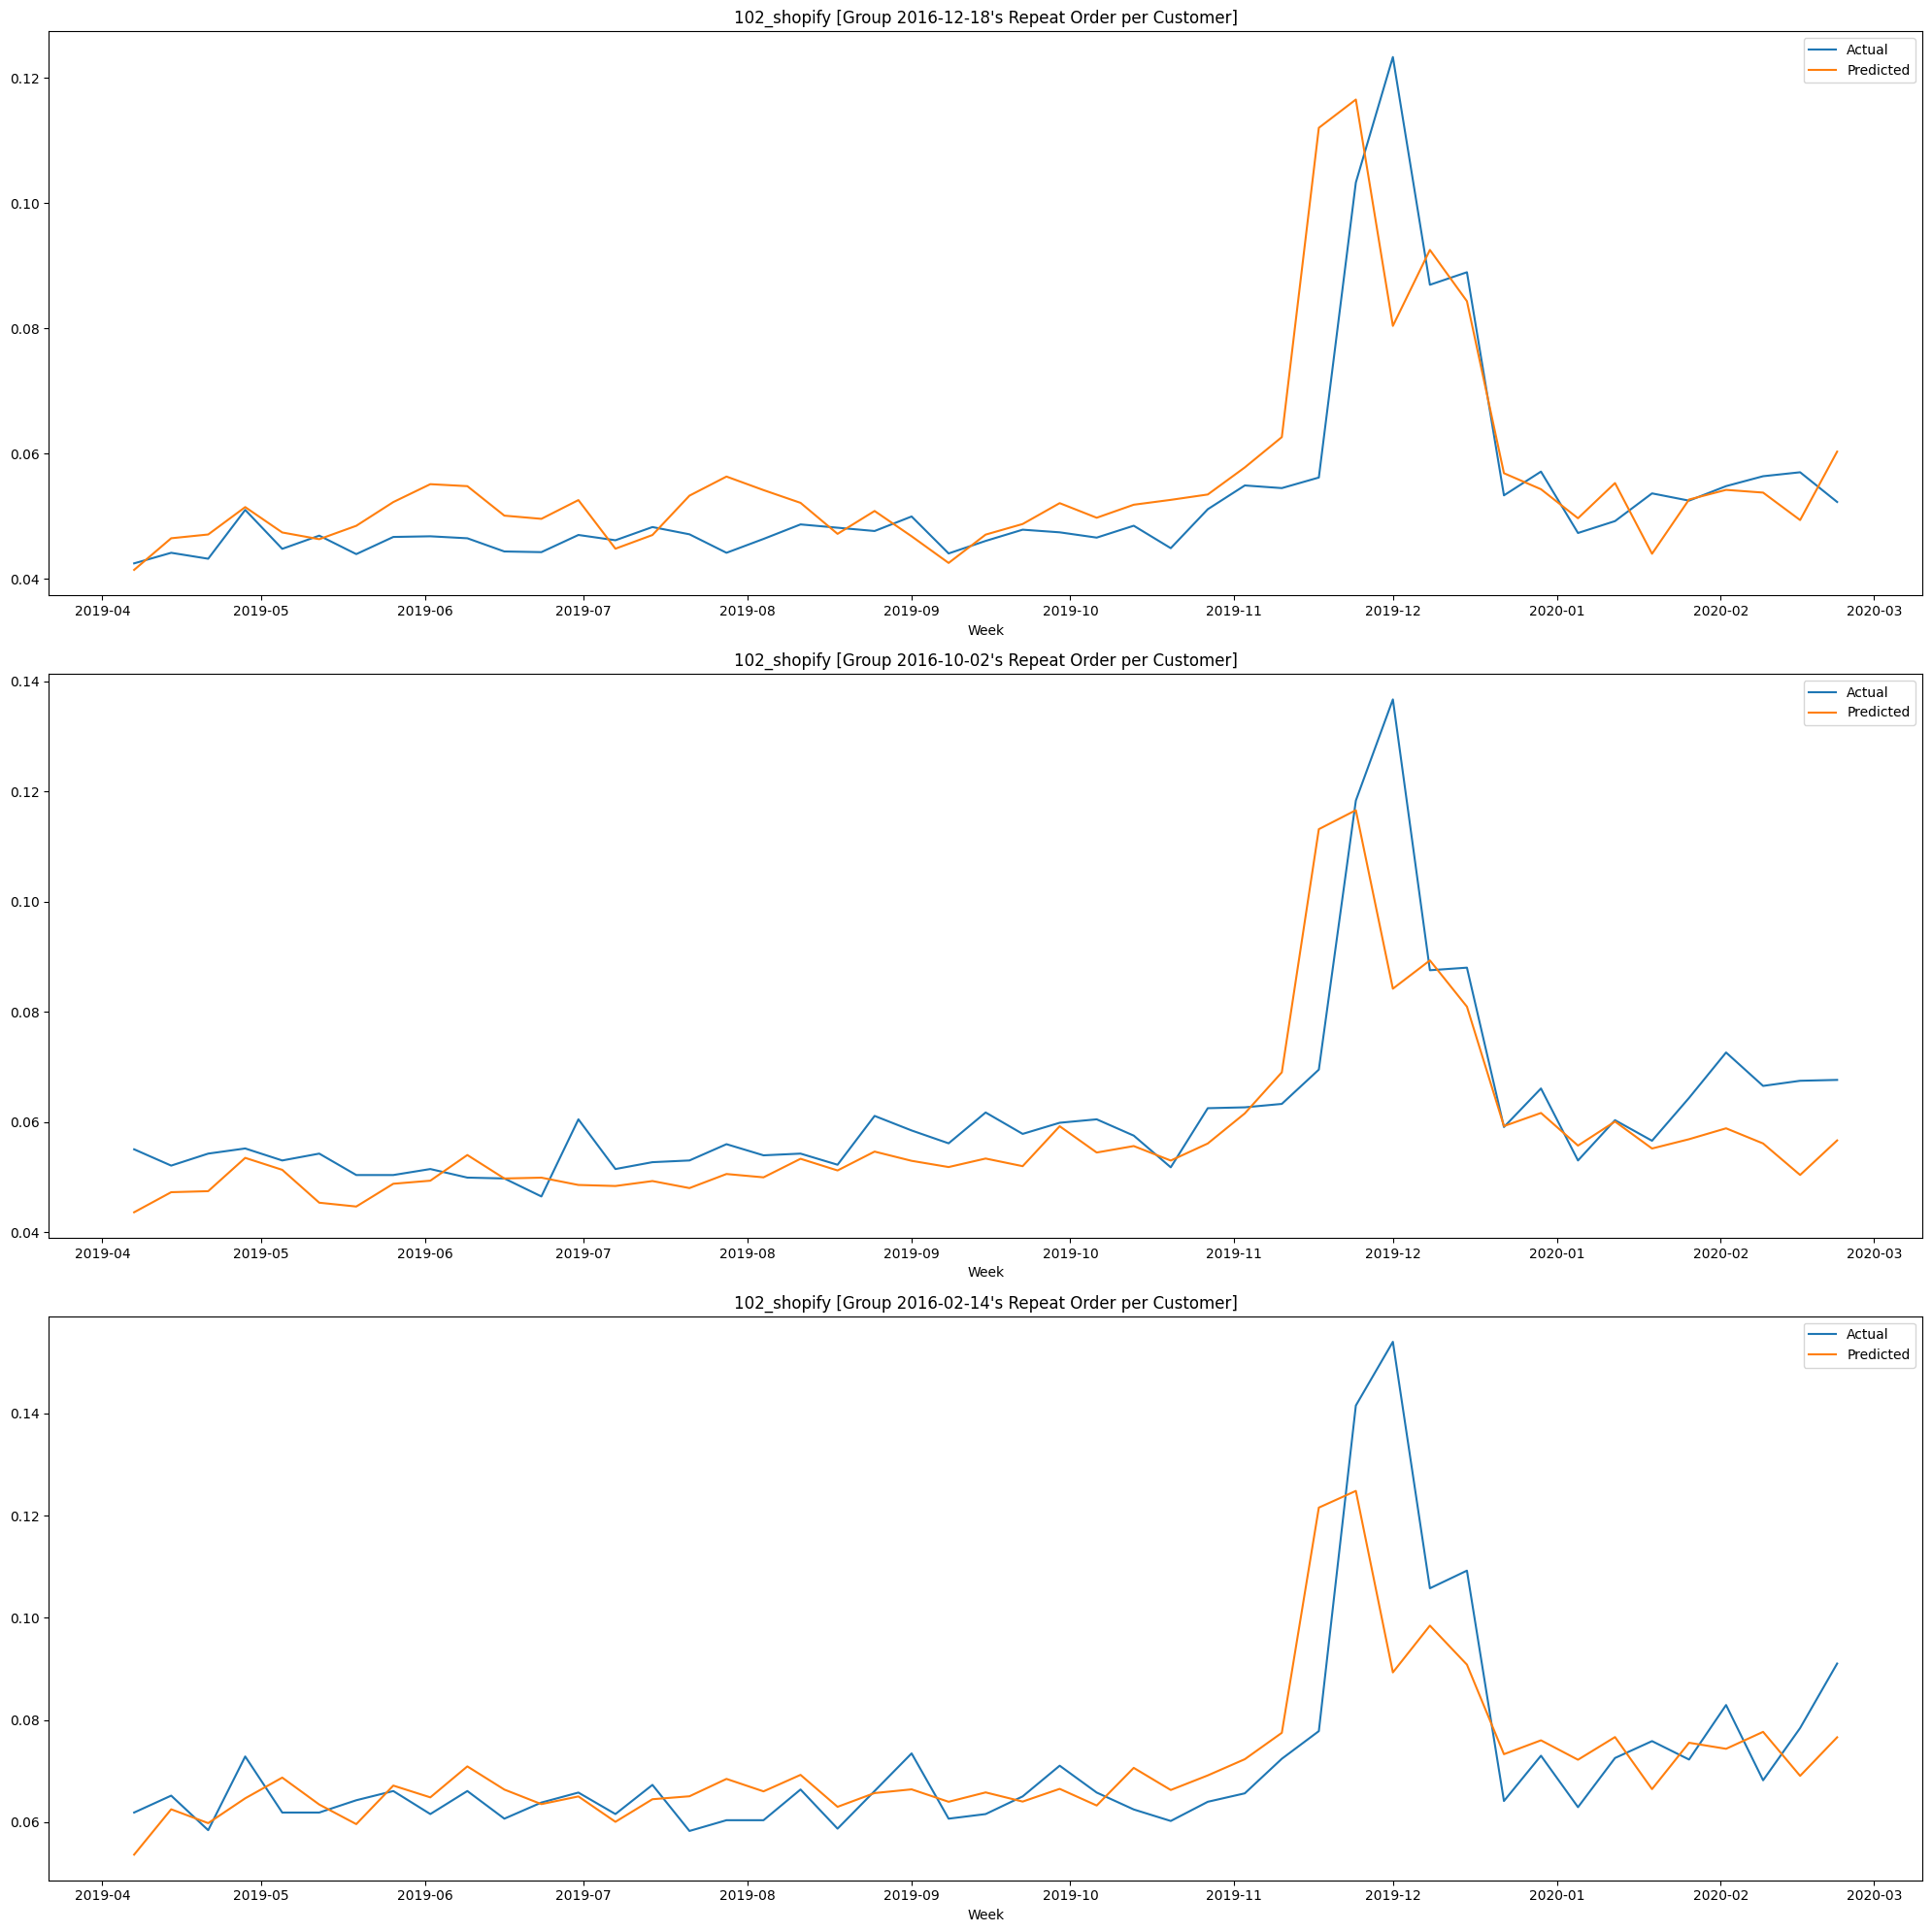

In [24]:
def plot_ropc_cohort0():
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))  # 5 rows, 1 column
    if len(censored_test_dict['group_seq']) < 3:
        selected_group_indices = range(len(censored_test_dict['group_seq']))
    else:
        selected_group_indices = random.sample(range(len(censored_test_dict['group_seq'])), 3)
    for i, group_index in enumerate(selected_group_indices):
        group = censored_test_dict['group_seq'][group_index]
        plot_time_series_multiple(
            actual_censored[actual_censored['group'] == group], predicted_censored[predicted_censored['group'] == group],
            'time', TARGET_TASK, 
            title=f'{MERCHANT_NAME} [Group {group}\'s Repeat Order per Customer]',
            ax=axs[i]
        )
    plt.tight_layout()

plot_ropc_cohort0()

In [25]:
from libs.plots import save_plots_to_pdf

if SAVE_MODE:
    # Saving plots to PDF
    save_plots_to_pdf([
        (plot_ropc_cohort1,{}),
        (plot_ropc_cohort0,{}),
        ], f'{SAVE_PLOT}/{MERCHANT_NAME}.pdf')
    
    # Saving traininig and validation losses
    save_plots_to_pdf([
        (plot_losses,{}),
        ], f'{SAVE_EPOCH}/{MERCHANT_NAME}_loss.pdf')
    
    # Saving csv files
    pd.concat([predicted_censored, predicted_main]).to_csv(f'{SAVE_PREDICT}/{MERCHANT_NAME}_pred.csv', index=False)
    pd.concat([actual_censored, actual_main]).to_csv(f'{SAVE_ACTUAL}/{MERCHANT_NAME}_actual.csv', index=False)
